## Example: Doing Extreme Value Analysis (EVA) for time series 

This example illustrates how to use to perform Extreme Value Analysis (EVA) based on time series stored in a netcdf, for example, this could be performed on a [GeoDataset](https://deltares.github.io/hydromt/latest/user_guide/data_types.html#geospatial-point-time-series-geodataset). Typical steps needed to perform EVA are:
- extract peaks (high extremes) from a continuous time series
- fit a EV distribution on these peaks 
- obtain return values for given return periods based on the distribution fitted and its parameters
- plot the distribution and empirical data 

All these steps are also combined in the function :py:meth:`eva` (see also the end of the example)

We cover these steps in this example using randomly generated data. More details on the functions used can be found in the API reference description of the [Statistics and Extreme Value Analysis](https://deltares.github.io/hydromt/latest/api.html#statistics)

In [1]:
# import hydromt and functions needed for EVA
import hydromt
from hydromt.stats import extremes
import xarray as xr
import pandas as pd
import numpy as np

We create some random continuous time series of 30 years with some extremes and store it in the xarray DataArray `da` for two stations (stations 1 and 2). 

In [2]:
# We create some random continuous time series with some extremes
rng = np.random.default_rng(12345) #For reproducibility
normal = pd.DataFrame(rng.random(size=(365*30,2)) * 100, index = pd.date_range(start="1950-01-01", periods=365*30, freq="1D"))
ext = rng.gumbel(loc=100, scale=25, size=(30,2)) #Create extremes
#replace extremes in normal values
for i in range(2):
    normal.loc[normal.nlargest(30, i).index, i] = ext[:,i].reshape(-1)
da = xr.DataArray(
    data = normal.values,
    dims=("time","stations"),
    coords={"time": pd.date_range(start="1950-01-01", periods=365*30, freq="D"), 
            "stations": [1,2]},
    attrs=dict(_FillValue=-9999),
)
da.raster.set_crs(4326)
da

<xarray.DataArray (time: 10950, stations: 2)>
array([[22.73360225, 31.67583397],
       [79.73654573, 67.62546708],
       [39.11095506, 33.28139279],
       ...,
       [18.43757982, 32.62441306],
       [56.81713587, 69.05312816],
       [28.08848113, 42.50184118]])
Coordinates:
  * time         (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1979-12-24
  * stations     (stations) int32 1 2
    spatial_ref  int32 0
Attributes:
    _FillValue:  -9999

Extreme value distribution fit is based either on block maxima (BM) or peaks-over-threshold (PoT). 

- If sampling of high extremes is done according to BM then, distributions to be fit are either Gumbel (later referred as `gumb`) or the Generalized Extreme Value (GEV) distribution (later referred as `gev`). Note that a GEV distribution with a shape paramater of 0 is equivalent to the Gumbel distribution.  

- If sampling of high extremes is done according to PoT then, distributions to be fit are either exponential (later referred as `exp`) or the Generalized Pareto (GP) distribution (later referred as `gpd`). 

For this example, we will fit a GEV distribution based on annual maxima. 

### Step 1: Extracting peaks from continuous time series

In [3]:
#We use the get_peaks function
bm_peaks = extremes.get_peaks(da, ev_type="BM", period="365.25D").load()
bm_peaks

<xarray.DataArray 'peaks' (time: 10950, stations: 2)>
array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1979-12-24
  * stations       (stations) int32 1 2
    spatial_ref    int32 0
    extremes_rate  (stations) float64 1.001 1.001
Attributes:
    _FillValue:  -9999

The function extracts peaks, here, annual maxima, and set the rest of the time series to NaN. Here, the `extremes_rate` is equal to 1 as we have sampled the highest value per year.

### Step 2: fit a EV distribution on these peaks 

In [4]:
da_params = extremes.fit_extremes(bm_peaks, ev_type="BM", distribution="gev").load()
da_params

<xarray.DataArray 'parameters' (stations: 2, dparams: 3)>
array([[ -0.46287272, 102.44626313,   7.42418934],
       [ -0.37771724, 104.69623192,  11.68952299]])
Coordinates:
  * stations       (stations) int32 1 2
    spatial_ref    int32 0
    extremes_rate  (stations) float64 1.001 1.001
  * dparams        (dparams) <U5 'shape' 'loc' 'scale'
    distribution   (stations) <U3 'gev' 'gev'

### Step 3: obtain return values for given return periods based on the distribution fitted and its parameters

In [5]:
#We define the return periods for which we would like to know the return values
rps = np.array([2,5,25,100,500])
da_rps = extremes.get_return_value(da_params, rps=rps).load()

print('The 2-year return level for station 1 is: ', da_rps.sel(stations=1, rps=2).values)
print('The 500-year return level for station 2 is: ', da_rps.sel(stations=2, rps=500).values)

da_rps

The 2-year return level for station 1 is:  105.42135060690681
The 500-year return level for station 2 is:  397.3699096546047


<xarray.DataArray 'return_values' (stations: 2, rps: 5)>
array([[105.42135061, 118.53462447, 156.92840329, 221.32684739,
        371.12682219],
       [109.3059576 , 128.30155683, 177.36891583, 249.68873617,
        397.36990965]])
Coordinates:
  * stations       (stations) int32 1 2
    spatial_ref    int32 0
    extremes_rate  (stations) float64 1.001 1.001
    distribution   (stations) <U3 'gev' 'gev'
  * rps            (rps) int32 2 5 25 100 500

### Step 4: plot the distribution and empirical data

<Axes: xlabel='Return period', ylabel='Return value'>

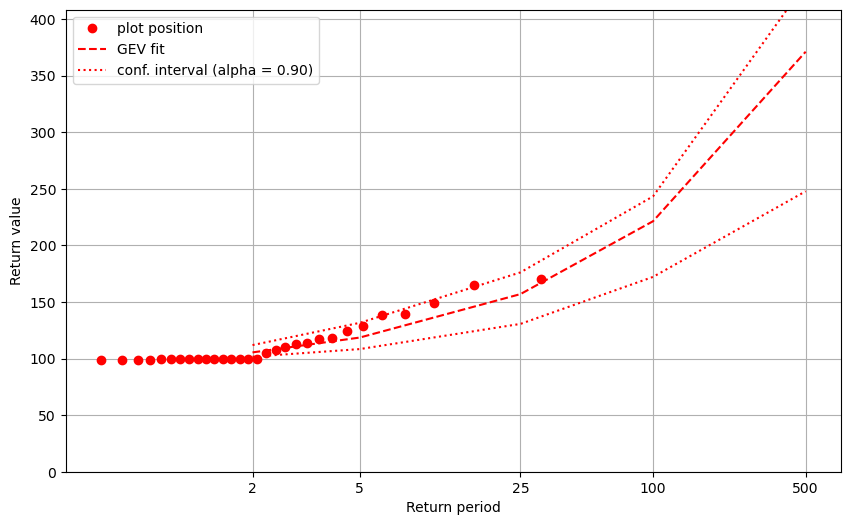

In [6]:
#We plot the fit obtained using the function plot_return_values!
extremes.plot_return_values(bm_peaks.sel(stations=1), da_params.sel(stations=1), "gev", x_scale="gumbel", ax=None, color="r", a=0, alpha=0.9, nsample=1000, rps=rps, extremes_rate=1.0)

## TL;DR
Note that the EV fit can be done within one function ([stats.extremes.eva]) that subsequently calls the functions used here ([stats.extremes.get_peaks], [stats.extremes.fit_extremes] and [stats.extremes.get_return_value])

Steps 1 to 3 above could have been performed using [stats.extremes.eva] as follow. In this case, it will return an xarray.Dataset:

In [7]:
da_bm_eva = extremes.eva(da, ev_type="BM", period="365.25D", distribution="gev", rps= rps).load()
da_bm_eva

#Note that for this example:
#da_bm_eva['peaks'] is the same as bm_peaks
#da_bm_eva['parameters'] is the same as da_params
#da_bm_eva['return_values'] is the same as da_rps



<xarray.Dataset>
Dimensions:        (time: 10950, stations: 2, dparams: 3, rps: 5)
Coordinates:
  * time           (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1979-12-24
  * stations       (stations) int32 1 2
    spatial_ref    int32 0
    extremes_rate  (stations) float64 1.001 1.001
  * dparams        (dparams) <U5 'shape' 'loc' 'scale'
    distribution   (stations) <U3 'gev' 'gev'
  * rps            (rps) int32 2 5 25 100 500
Data variables:
    peaks          (time, stations) float64 nan nan nan nan ... nan nan nan nan
    parameters     (stations, dparams) float64 -0.4629 102.4 ... 104.7 11.69
    return_values  (stations, rps) float64 105.4 118.5 156.9 ... 249.7 397.4
Attributes:
    _FillValue:  -9999